To get started, let's import graphcat and create an empty computational graph:

In [1]:
import graphcat
graph = graphcat.StaticGraph()

The first step in our workflow will be to load an image from disk.  We're going to use [Pillow](https://pillow.readthedocs.org) to do the heavy lifting, so you'll need to install it with

    $ pip install pillow
    
if you don't already have it.  With that out of the way, the first thing we need is a parameter with the filename of the image to be loaded.  In Graphcat, everything that affects your computation - including parameters - should be represented as a task:

In [2]:
graph.set_task("filename", graphcat.constant("astronaut.jpg"))

In [3]:
import PIL.Image

def load(graph, name, inputs):
    path = inputs.get("path")
    return PIL.Image.open(path)

graph.set_task("load", load)

The `load` function expects an input named *path* which will supply the filename to be loaded, and returns a Pillow image as output.  Our "filename" task produces a filename, so we connect it to the "load" task's *path* input:

In [4]:
graph.set_links("filename", ("load", "path"))

Finally, let's stop and take stock of what we've done so far, with a diagram of the current computational graph:

In [5]:
import graphcat.notebook
graphcat.notebook.display(graph)

 For our next step, we'll resize the incoming image:

In [6]:
def resize(graph, name, inputs):
    image = inputs.get("image")
    scale = inputs.get("scale")
    return image.resize((int(image.width * scale), int(image.height * scale)))

graph.set_task("resize", resize)

In [7]:
graph.set_parameter(target="resize", input="scale", source="scale_parameter", value=0.2)



And of course, we need to connect the `load` function to `resize`:

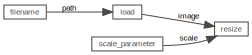

In [8]:
graph.set_links("load", ("resize", "image"))

graphcat.notebook.display(graph)

Before going any further, let's execute the current graph to see what the loaded image looks like:

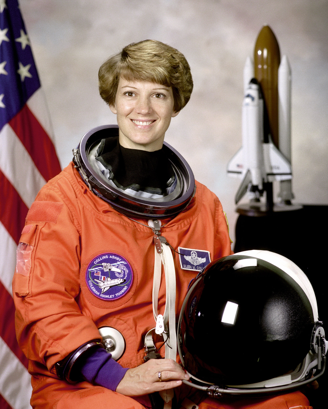

In [9]:
graph.output("resize")

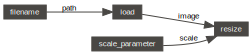

In [10]:
graphcat.notebook.display(graph)

Creating the blurred version of the input image works much like the resize operation - the `blur` task function takes an image and a blur radius as inputs, and produces a modified image as output:

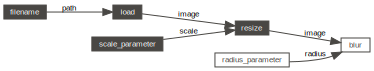

In [11]:
import PIL.ImageFilter

def blur(graph, name, inputs):
    image = inputs.get("image")
    radius = inputs.get("radius")
    return image.filter(PIL.ImageFilter.GaussianBlur(radius))

graph.set_task("blur", blur)
graph.set_parameter("blur", "radius", "radius_parameter", 5)

graph.set_links("resize", ("blur", "image"))

graphcat.notebook.display(graph)

Notice that the tasks we just added have white backgrounds in the diagram, indicating that they haven't been executed yet.

Now, we're ready to combine the blurred and unblurred versions of the image.  Notably, our "blend" task will take *three* inputs: one for each version of the image, plus one for the "alpha" parameter that will control how much each image contributes to the final result:

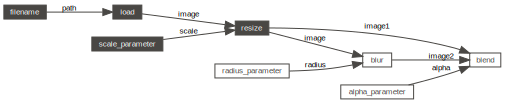

In [12]:
import PIL.ImageChops

def blend(graph, name, inputs):
    image1 = inputs.get("image1")
    image2 = inputs.get("image2")
    alpha = inputs.get("alpha")
    return PIL.ImageChops.blend(image1, image2, alpha)

graph.set_task("blend", blend)
graph.set_parameter("blend", "alpha", "alpha_parameter", 0.65)
graph.add_links("resize", ("blend", "image1"))
graph.set_links("blur", ("blend", "image2"))

graphcat.notebook.display(graph)

That's it!  Now we're ready to execute the graph and see the softened result:

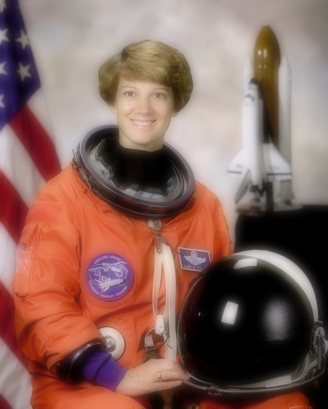

In [13]:
graph.output("blend")

Don't ask how, but I can confirm that the image now looks like it was taken in a department store, circa 1975.

Of course, executing the graph once doesn't really demonstrate Graphcat's true abilities.  The real benefit of a computational graph only becomes clear when its parameters are changing, with the graph only executing the tasks that need to be recomputed.

To demonstrate this, we will use Jupyter notebook widgets - https://ipywidgets.readthedocs.io - to provide a simple, interactive user interface.  In particular, we'll use interactive sliders to drive the "scale", "radius", and "alpha" parameters in the computational graph.  We won't discuss how the widgets work in any detail, focusing instead on just the places where they are integrated with Graphcat.  To begin, we will need to define some callback functions that will be called when the value of a widget changes:

In [14]:
def set_graph_value(name):
    def implementation(change):
        graph.set_task(name, graphcat.constant(change["new"]))
    return implementation

In [15]:
import ipywidgets as widgets

scale_widget = widgets.FloatSlider(description="scale:", min=0.01, max=1, value=0.2, step=0.01, continuous_update=False)
scale_widget.observe(set_graph_value("scale_parameter"), names="value")

radius_widget = widgets.FloatSlider(description="radius:", min=0, max=10, value=5, step=1, continuous_update=False)
radius_widget.observe(set_graph_value("radius_parameter"), names="value")

alpha_widget = widgets.FloatSlider(description="alpha:", min=0, max=1, value=0.7, step=0.01, continuous_update=False)
alpha_widget.observe(set_graph_value("alpha_parameter"), names="value")

We'll also need an output widget where our results will be displayed:

In [16]:
output_widget = widgets.Output()
output_widget.layout.height="1000px"

So we can see exactly which tasks are executed when a slider is moved, we will create our own custom logging function and connect it to the graph:

In [17]:
def log_execution(graph, name, inputs):
    with output_widget:
        print(f"Executing {name}")
        
graph.on_execute.connect(log_execution);

This function will be called every time a task is executed.

We also need a function that will be called whenever the graph changes.  This function will be responsible for clearing the previous output, displaying an up-to-date graph diagram, and displaying the new graph output:

In [18]:
import IPython.display

def graph_changed(graph):
    with output_widget:
        IPython.display.clear_output(wait=True)
        graphcat.notebook.display(graph)
        IPython.display.display(graph.output("blend"))

graph.on_changed.connect(graph_changed);

In [19]:
IPython.display.display(scale_widget)
IPython.display.display(radius_widget)
IPython.display.display(alpha_widget)
IPython.display.display(output_widget)

graph_changed(graph)

FloatSlider(value=0.2, continuous_update=False, description='scale:', max=1.0, min=0.01, step=0.01)

FloatSlider(value=5.0, continuous_update=False, description='radius:', max=10.0, step=1.0)

FloatSlider(value=0.7, continuous_update=False, description='alpha:', max=1.0, step=0.01)

Output(layout=Layout(height='1000px'))